# Shakespeare Text Generation (using RNN LSTM)

> - 🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on **GitHub**<br/><br/>
> - ▶️ **Interactive Demo**: [try this model and other machine learning experiments in action](https://trekhleb.github.io/machine-learning-experiments/)

## Experiment overview

In this experiment we will use character-based [Recurrent Neural Network](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNN) to generate a Shakespeare's-like text based on the Shakespeare dataset from [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) blog post.

For this experiment we will use [Tensorflow v2](https://www.tensorflow.org/) with its [Keras API](https://www.tensorflow.org/guide/keras).

![text_generation_shakespeare_rnn.jpg](https://github.com/trekhleb/machine-learning-experiments/blob/master/demos/src/images/text_generation_shakespeare_rnn.jpg?raw=1)

_Inspired by [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation)_

## Import dependencies

In [1]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [1]:
import  torch
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', torch.__version__)


Python version: 3.9.19
Tensorflow version: 2.3.1


## Download the dataset

In [3]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'
# Create a cache directory.
cache_dir_path = pathlib.Path(cache_dir).absolute()
cache_dir_path.mkdir(parents=True,exist_ok=True)

# Download the dataset.
dataset_file_path = cache_dir_path/dataset_file_name
torch.hub.download_url_to_file(dataset_file_origin,dataset_file_path)

print(f"Dataset file downloaded to {dataset_file_path}")

100.0%

Dataset file downloaded to /Users/aaronpang/PycharmProjects/FedAvg/tmp/shakespeare.txt


## Analyze the dataset

In [4]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [5]:
# Take a look at the first 250 characters in text.
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [6]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Process the dataset

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [7]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [8]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [9]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 1115394
'First Citizen:\n' --> array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0])


## Create training sequences

In [10]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [18]:
from torch.utils.data import Dataset


class CharDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        input_text = self.data[idx:idx + self.seq_length]
        target_text = self.data[idx + 1:idx + self.seq_length + 1]
        return input_text, target_text
# transform to pytorch tensor
text_as_int_tensor = torch.tensor(text_as_int, dtype=torch.long)
# create a dataset
char_dataset = CharDataset(torch.tensor(text_as_int, dtype=torch.long), sequence_length)

print('char_dataset size:', len(char_dataset))

char_dataset size: 1115294


In [24]:
from torch.utils.data import DataLoader

# Generate batched sequences out of the char_dataset.
dataloader = DataLoader(char_dataset, batch_size=1, shuffle=False)

# Sequences size is the same as examples_per_epoch.
sequences_count = len(dataloader)
print('Sequences count: {}'.format(sequences_count))
print()

# Sequences examples.
index2char = {i: char for char, i in char2index.items()} 
# for i, batch in enumerate(dataloader):
#     if i >= 5:
#         break
#     sequence = batch[0].numpy()
#     print(sequence[0].shape)
#     print(repr(''.join([index2char[(idx)] for idx in sequence])))

Sequences count: 1115294



In [25]:
# sequences shape:
# - 11043 sequences
# - Each sequence of length 101
#
#
#    101     101          101
# [(.....) (.....) ...  (.....)]
#
# <---------- 11043 ----------->

For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [26]:

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.


AttributeError: 'DataLoader' object has no attribute 'as_numpy_iterator'

In [27]:
for input_example, target_example in dataloader:
    print('Input sequence size:', repr(len(input_example[0])))
    print('Target sequence size:', repr(len(target_example[0])))
    print()
    print('Input:', repr(''.join([index2char[int(idx)] for idx in input_example[0]])))
    print('Target:', repr(''.join([index2char[int(idx)] for idx in target_example[0]])))
    break

Input sequence size: 100
Target sequence size: 100

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [28]:
# dataset shape:
# - 11043 sequences
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#    100       100           100
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text
#
# <----------- 11043 ------------->

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [30]:
from torch.utils.data import RandomSampler
for input_example, target_example in dataloader:
    print('Input sequence size:', repr(len(input_example[0])))
    print('Target sequence size:', repr(len(target_example[0])))
    print()
    print('Input:', repr(''.join([index2char[int(idx)] for idx in input_example[0]])))
    print('Target:', repr(''.join([index2char[int(idx)] for idx in target_example[0]])))

   
    for i, (input_idx, target_idx) in enumerate(zip(input_example[0][:5], target_example[0][:5])):
        print('Step {:2d}'.format(i))
        print('  input: {} ({:s})'.format(input_idx.item(), repr(index2char[input_idx.item()])))
        print('  expected output: {} ({:s})'.format(target_idx.item(), repr(index2char[target_idx.item()])))
    break 

Input sequence size: 100
Target sequence size: 100

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
Step  0
  input: 18 ('F')
  expected output: 47 ('i')
Step  1
  input: 47 ('i')
  expected output: 56 ('r')
Step  2
  input: 56 ('r')
  expected output: 57 ('s')
Step  3
  input: 57 ('s')
  expected output: 58 ('t')
Step  4
  input: 58 ('t')
  expected output: 1 (' ')


## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [32]:
from torch.utils.data import Dataset, DataLoader, RandomSampler
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

sampler = RandomSampler(char_dataset, replacement=False)
# Create a dataset from the sequences.
dataloader = DataLoader(char_dataset, batch_size=BATCH_SIZE, sampler=sampler, drop_last=True)




In [33]:
# 打印一个批次的输入序列和目标序列大小及内容
for input_example, target_example in dataloader:
    print('Input sequence size:', repr(len(input_example[0])))
    print('Target sequence size:', repr(len(target_example[0])))
    print()
    print('Input:', repr(''.join([index2char[int(idx)] for idx in input_example[0]])))
    print('Target:', repr(''.join([index2char[int(idx)] for idx in target_example[0]])))

   
    for i, (input_idx, target_idx) in enumerate(zip(input_example[0][:5], target_example[0][:5])):
        print('Step {:2d}'.format(i))
        print('  input: {} ({:s})'.format(input_idx.item(), repr(index2char[input_idx.item()])))
        print('  expected output: {} ({:s})'.format(target_idx.item(), repr(index2char[target_idx.item()])))
    break  

Input sequence size: 100
Target sequence size: 100

Input: "\nIn suffering thus thy brother to be slaughter'd,\nThou showest the naked pathway to thy life,\nTeachi"
Target: "In suffering thus thy brother to be slaughter'd,\nThou showest the naked pathway to thy life,\nTeachin"
Step  0
  input: 0 ('\n')
  expected output: 21 ('I')
Step  1
  input: 21 ('I')
  expected output: 52 ('n')
Step  2
  input: 52 ('n')
  expected output: 1 (' ')
Step  3
  input: 1 (' ')
  expected output: 57 ('s')
Step  4
  input: 57 ('s')
  expected output: 59 ('u')


In [34]:
for input_text, target_text in dataloader:
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)
    break

1st batch: input_text: tensor([[39, 61, 39,  ..., 58, 56, 59],
        [47, 58,  1,  ..., 40, 43,  1],
        [56, 58, 46,  ...,  1, 39, 56],
        ...,
        [58, 46, 63,  ...,  1, 58, 46],
        [58, 43,  1,  ..., 60, 53, 57],
        [58,  1, 44,  ..., 52,  1, 51]])

1st batch: target_text: tensor([[61, 39, 63,  ..., 56, 59, 41],
        [58,  1, 61,  ..., 43,  1, 44],
        [58, 46,  1,  ..., 39, 56, 51],
        ...,
        [46, 63,  1,  ..., 58, 46, 43],
        [43,  1, 51,  ..., 53, 57, 58],
        [ 1, 44, 39,  ...,  1, 51, 53]])


In [35]:
# dataset shape:
# - 172 batches
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     100       100           100             100       100           100
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->
#
# <--------------------------------- 172 ----------------------------------->

## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this simple example three layers are used to define our model:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [22]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

1/1 [==============================] - 0s 86ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[1 4 8 9 0 1 9 1]
 [2 0 2 9 7 4 3 7]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[-0.0132779  -0.03334284 -0.03207427 -0.01366842  0.00392176]
  [ 0.04571239  0.03155562 -0.003222    0.02832833  0.03711155]
  [ 0.0167073  -0.02178857  0.02521649  0.02425206 -0.01864066]
  [-0.03676196 -0.00633899 -0.01282347  0.02390226  0.03727164]
  [ 0.03050851 -0.00148927 -0.0121984   0.01500933 -0.02329093]
  [-0.0132779  -0.03334284 -0.03207427 -0.01366842  0.00392176]
  [-0.03676196 -0.00633899 -0.01282347  0.02390226  0.03727164]
  [-0.0132779  -0.03334284 -0.03207427 -0.01366842  0.00392176]]

 [[-0.02808646 -0.0143191  -0.00118178  0.03838519  0.01635638]
  [ 0.03050851 -0.00148927 -0.0121984   0.01500933 -0.02329093]
  [-0.02808646 -0.0143191  -0.00118178  0.03838519  0.01635638]
  [-0.03676196 -0.00633899 -0.01282347  0.02390226  0.03727164]
  [-0.01684532  0.0377759  -0.0400447  

In [39]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.

rnn_units = 1024

In [42]:
import torch.nn as nn
from torchsummary import summary
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_units, batch_size):
        super(CharRNN, self).__init__()
        self.batch_size = batch_size
        self.rnn_units = rnn_units
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, rnn_units, batch_first=True)
        self.fc = nn.Linear(rnn_units, vocab_size)

    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(x.size(0))
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = self.fc(x)
        return x, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.rnn_units).to(device),
                torch.zeros(1, batch_size, self.rnn_units).to(device))


In [45]:
model = CharRNN(vocab_size, embedding_dim, rnn_units, batch_size=BATCH_SIZE)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


CharRNN(
  (embedding): Embedding(65, 256)
  (lstm): LSTM(256, 1024, batch_first=True)
  (fc): Linear(in_features=1024, out_features=65, bias=True)
)

## Try the model

In [47]:
for input_example_batch, target_example_batch in dataloader:
    input_example_batch, target_example_batch = input_example_batch.to(device), target_example_batch.to(device)
    example_batch_predictions, _ = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
    break

torch.Size([64, 100, 65]) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [48]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tensor([ 0.0401, -0.0206,  0.0219,  0.0710,  0.0311, -0.0095,  0.0124, -0.0079,
         0.0292,  0.1018,  0.0646, -0.0281,  0.0469,  0.0480,  0.0030,  0.0662,
         0.0129,  0.0310, -0.0511,  0.0047,  0.0065,  0.0511, -0.0577, -0.0022,
        -0.0701,  0.0361, -0.0090, -0.0182, -0.0607, -0.0246, -0.0343,  0.0300,
         0.0792, -0.0069, -0.0371, -0.0047,  0.0062,  0.0391, -0.0204, -0.0584,
         0.0083, -0.0049, -0.0144,  0.0233,  0.0368,  0.0125,  0.0641, -0.0099,
        -0.0405,  0.0259,  0.0144, -0.0295,  0.0533, -0.0215, -0.0580,  0.0259,
        -0.0427, -0.0441,  0.0565,  0.0520, -0.0086,  0.0144,  0.0163,  0.0492,
        -0.0185], grad_fn=<SelectBackward0>)


In [30]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 2 2 1]], shape=(1, 5), dtype=int64)


In [31]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [32]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [33]:
sampled_indices

array([20, 53, 62, 27, 37, 46, 48, 24, 30, 17, 63,  1, 57, 23, 31, 22,  0,
       50, 63, 58, 64, 35, 49, 16, 35, 64,  0, 59, 30, 24, 54, 48,  6, 42,
       24, 56, 59, 27,  0, 56, 51, 27,  4, 30, 11, 48,  6, 16,  1,  0, 50,
       37, 26, 51, 22, 17, 35, 39, 44, 22, 14, 18, 17,  8, 57, 38,  6, 56,
       63, 47,  2, 55, 64, 27, 57, 20, 56, 17,  1, 42, 21,  2, 28, 20, 22,
       57, 52, 48,  5, 34, 22,  6, 29, 10, 59,  4, 31, 23, 10, 52])

In [34]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 ' puts his armour on.\n\nPRINCE EDWARD:\nIf that be right which Warwick says is right,\nThere is no wrong'

Next char prediction:
 "HoxOYhjLREy sKSJ\nlytzWkDWz\nuRLpj,dLruO\nrmO&R;j,D \nlYNmJEWafJBFE.sZ,ryi!qzOsHrE dI!PHJsnj'VJ,Q:u&SK:n"


In [49]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

NameError: name 'sampled_indices' is not defined

## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [50]:


# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Example logits (output from the model) and labels (target)
example_batch_predictions = torch.randn(BATCH_SIZE, sequence_length, vocab_size, requires_grad=True).to(device)  # Example model output
target_example_batch = torch.randint(0, vocab_size, (BATCH_SIZE, sequence_length)).to(device)  # Example targets

# Reshape logits and labels for calculating loss
# PyTorch's CrossEntropyLoss expects input of shape (batch_size * sequence_length, vocab_size) and targets of shape (batch_size * sequence_length)
example_batch_predictions = example_batch_predictions.view(-1, vocab_size)
target_example_batch = target_example_batch.view(-1)

# Calculate the loss
example_batch_loss = loss_fn(example_batch_predictions, target_example_batch)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size * sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.item())


Prediction shape:  torch.Size([6400, 65])  # (batch_size * sequence_length, vocab_size)
scalar_loss:       4.6611328125


In [51]:
import torch.optim as optim
loss_fn = nn.CrossEntropyLoss()
adam_optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example training step
def train_step(input_text, target_text):
    model.train()  # Set the model to training mode
    hidden = model.init_hidden(BATCH_SIZE)
    
    # Zero the gradients
    adam_optimizer.zero_grad()
    
    # Forward pass
    output, hidden = model(input_text, hidden)
    
    # Reshape output and target for the loss function
    output = output.view(-1, vocab_size)
    target = target_text.view(-1)
    
    # Compute the loss
    loss = loss_fn(output, target)
    
    # Backward pass and optimization
    loss.backward()
    adam_optimizer.step()
    
    return loss.item()

# Example usage with the dataloader
for input_example_batch, target_example_batch in dataloader:
    input_example_batch, target_example_batch = input_example_batch.to(device), target_example_batch.to(device)
    loss_value = train_step(input_example_batch, target_example_batch)
    print("Loss: ", loss_value)
    break  # Only run one batch for demonstration

Loss:  4.184051513671875


### Configure checkpoints

In [ ]:
EPOCHS=40
# Custom function to save checkpoints
def save_checkpoint(model, optimizer, epoch, loss, checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, f'ckpt_{epoch}.pt')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }, checkpoint_path)
    print(f'Saved checkpoint: {checkpoint_path}')
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
training_losses = []
# Training loop
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for input_example_batch, target_example_batch in dataloader:
        input_example_batch, target_example_batch = input_example_batch.to(device), target_example_batch.to(device)
        adam_optimizer.zero_grad()
        output, hidden = model(input_example_batch)
        output = output.view(-1, vocab_size)
        target_example_batch = target_example_batch.view(-1)
        loss = loss_fn(output, target_example_batch)
        loss.backward()
        adam_optimizer.step()
        epoch_loss += loss.item()

    training_losses.append(epoch_loss / len(dataloader))
    
    # Save checkpoint at the end of the epoch
    save_checkpoint(model, adam_optimizer, epoch, epoch_loss, checkpoint_dir)
    print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss / len(dataloader)}')

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

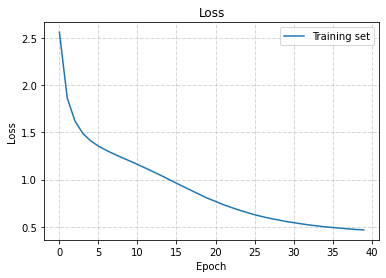

In [ ]:
render_training_history(training_losses)

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_40'

In [ ]:
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

![Prediction loop](https://www.tensorflow.org/tutorials/text/images/text_generation_sampling.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

In [ ]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [ ]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: God do not burden me.

GREMIO:
I want the king that murders writ upon your tongue
And born too supplict, but thanks
We should to him and nothing can I never my
brothers forbeard our words:
Confess which have wine, and provide thee
And see how did bestride our nobising duke,
Whose souls more pleased, that men are worst challenge into a farmet together
Let hate not so, for these own with him.

Tailors:
But now the blood of two,
You and your accused find your wars.

MENENIUS:
Part not chastisement; hidest me well arm'd
With eterpity of the mon poor house.

Third Servant:
When you are gentlemen, some interr'd
As is my goods, God says King Richard say,
As is the sin that she doth aim at you
As I could pick my daughter woful side!
Thou follow'st me in his life, against your husband's land:
My lawful king is dead! wis gone to ET:
Where is my woful? Was never man so bath
Lord Her further.

BRUTUS:
Let me prepare from fair, nor ambition
That spucish him our absence, like a grave is no mo

In [ ]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"ROMEO: ", temperature=1.5))

ROMEO: hexen his virginallike.

BRUTUS:
For thyself
Look, sirr; let not this innocent mine friends
And hateful dogs as appeared, for it exced
Exelling clouds with gentle knterpleaking:
Their liberal dogs not his;
For Yorkome help, ho! ay, I trow:
it will we meet us king E:
Needs friends, father, in that mad bessisking in
Whom I might thrive is rich'd die by thee?

CORIOLANUS:
Brak how, gnow roaring with Sicils
Up Jusul's dee Signior Katharina,
And thyself shalt hear of that which the ear o' Lord:
You are the first gape on me at first,
Thou lovest me wash:
By heaven, I'll haughthere.
O, gentle marvantio; and beginn pluck'd
But the christs and Riciards a
LUUMEOfoke fray,
And yet whick, in my doesder differences be runed by the king,
Who in his monthry glorious regeal death.
O, that she smooth thy cause?
Was e turn be so
to thine as thee won that Edward, king, widdwisk
Ere te goil: deserve not thy mother leave for reason
many an hourable fought, as they do,
If you should esear mon-judgmen

## Save the model

In [ ]:
model_name = 'text_generation_shakespeare_rnn.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.h5 \
  ./demos/public/models/text_generation_shakespeare_rnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.